In [1]:
import torch
import torchvision
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import sys
import os
src_path = os.path.join('..', 'scripts')
if src_path not in sys.path:
    sys.path.append(src_path)
sys.path

from train_cyclegan import ImageWindowDataset, train_model
from cyclegan_models import GeneratorModel, PatchGANDiscriminator

In [3]:
help(ImageWindowDataset.__init__)

Help on function __init__ in module train_cyclegan:

__init__(self, window_df: pandas.core.frame.DataFrame, image_dir, defect_classes=None, num_samples=None, random_state=42, device=None)
    Initialize self.  See help(type(self)) for accurate signature.



In [4]:
df = pd.read_csv(os.path.join('..', 'data', 'windows.csv'), index_col=0)
display(df)
defect_images = ImageWindowDataset(df, defect_classes=[1], image_dir=os.path.join('..', 'data', 'train_images'), num_samples=100)

df = pd.read_csv(os.path.join('..', 'data', 'undefective_windows.csv'), index_col=0)
display(df)
undefective_images = ImageWindowDataset(df, image_dir=os.path.join('..', 'data', 'train_images'), num_samples=100)

Index        ImageId  ClassId  instance_center_x  instance_min_x  \
0         1  0002cc93b.jpg        1         342.052478             332   
1         2  0002cc93b.jpg        1         120.164223             113   
2         4  0002cc93b.jpg        1         747.768571             741   
3         5  0007a71bf.jpg        3        1155.511409            1145   
4        21  005f02e20.jpg        3        1268.437154            1244   
...     ...            ...      ...                ...             ...   
7490  16218  ffff4eaa8.jpg        3         101.358385              66   
7491  16219  ffff4eaa8.jpg        3         387.758572             372   
7492  16220  ffff4eaa8.jpg        3         577.653570             564   
7493  16221  ffff4eaa8.jpg        3         263.270396             252   
7494  16222  ffffd67df.jpg        3         131.007099             120   

      instance_max_x  instance_std_x  instance_size  window_size  \
0                355        5.489558             23          160   
1                127        4.188661             14          160   
2                755        3.697201             14          160   
3               1167        6.364029             22          160   
4               1296       13.235993             52          160   
...              ...             ...            ...          ...   
7490             140       16.610888             74          160   
7491             403        7.063772             31          160   
7492             591        5.821356             27          160   
7493             275        5.788046             23          160   
7494             142        5.847867             22          160   

      all_instances_fit_in_window  all_overlapping_appx_centered  
0                            True                           True  
1                            True                           True  
2                            True                           True  
3                            True                           True  
4                            True                           True  
...                           ...                            ...  
7490                         True                           True  
7491                         True                           True  
7492                         True                           True  
7493                         True                           True  
7494                         True                           True  

[7495 rows x 11 columns]

2022-09-28 20:47:43,672 Using device: cuda
2022-09-28 20:47:43,674 Using only defect classes [1]
2022-09-28 20:47:43,679 Taking 100 samples


Index        ImageId  ClassId  instance_center_x  window_size
0       526  53abc091a.jpg        0               1194          160
1      3863  a733a2220.jpg        0                711          160
2      1189  083134687.jpg        0                215          160
3      4342  d8a2472a7.jpg        0               1176          160
4      3029  9e5b91357.jpg        0                264          160
...     ...            ...      ...                ...          ...
6629   2312  f60a5bc2b.jpg        0                198          160
6630   5572  1c3efa3ca.jpg        0               1335          160
6631   2097  a9dcd6f0b.jpg        0               1405          160
6632   5311  77128fb28.jpg        0                521          160
6633   5010  f8a56ce6e.jpg        0                114          160

[6634 rows x 5 columns]

2022-09-28 20:47:43,698 Using device: cuda
2022-09-28 20:47:43,698 Taking 100 samples


In [5]:
defect_images[0].dtype

torch.float32

In [6]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i, ax in enumerate(axes.flat):
#     img = defect_images[i]
#     ax.imshow(img.numpy().transpose((1, 2, 0)))

In [7]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for i, ax in enumerate(axes.flat):
#     img = undefective_images[i]
#     ax.imshow(img.numpy().transpose((1, 2, 0)))

In [8]:
help(train_model)

Help on function train_model in module train_cyclegan:

train_model(x_gen, x_disc, y_gen, y_disc, x_domain, y_domain, n_epochs=10)
    Jointly trains 4 networks (2 generators and 2 discriminators) that are cyclically
    linked to learn conditional mappings from an x domain to a y domain of images.
    
    :param x_gen:  Generator network from domain x to domain y.
    :param x_disc: Discriminator network for domain x. Indicates likelihood images are in domain x.
    :param y_gen:  Generator network from domain y to domain x.
    :param y_disc: Discriminator network for domain y. Indicates likelihood images are in domain y.
    :param x_domain: DataLoader yielding training images in the x domain.
    :param y_domain: DataLoader yielding training images in the y domain.



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device {device}')

batch_size = 50

x_disc = PatchGANDiscriminator(cin=1).to(device)
x_gen = GeneratorModel(cin=1).to(device)
x_domain = torch.utils.data.DataLoader(defect_images, batch_size=batch_size, pin_memory=True)

y_disc = PatchGANDiscriminator(cin=1).to(device)
y_gen = GeneratorModel(cin=1).to(device)
y_domain = torch.utils.data.DataLoader(undefective_images, batch_size=batch_size, pin_memory=True)

x_gen, x_disc, y_gen, y_disc = train_model(x_gen, x_disc, y_gen, y_disc, x_domain, y_domain, n_epochs=100)

Using device cuda


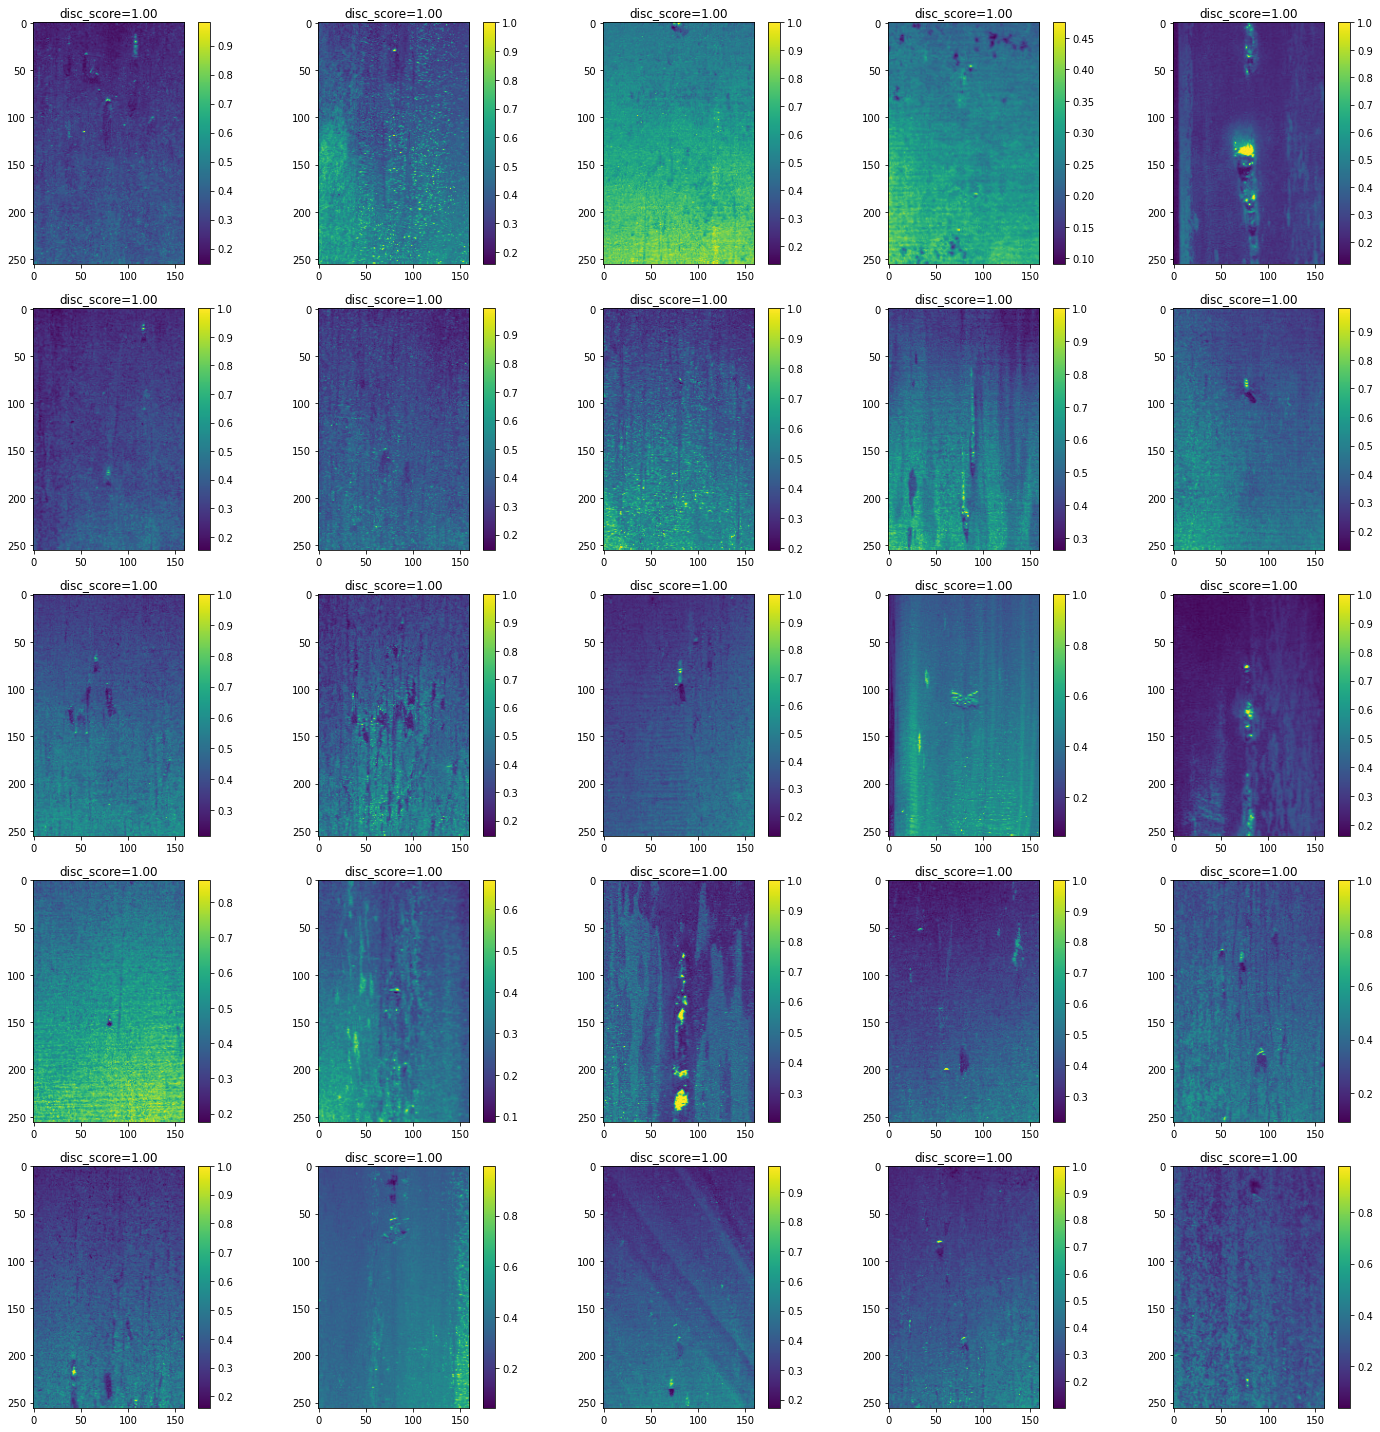

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    img = defect_images[i]
    mappable = ax.imshow(img.numpy().transpose((1, 2, 0)))
    plt.colorbar(mappable, ax=ax)
    with torch.no_grad():
        disc_score = x_disc(img.to('cuda').unsqueeze(0))
    ax.set_title(f'disc_score={disc_score.item():.2f}')
plt.tight_layout()

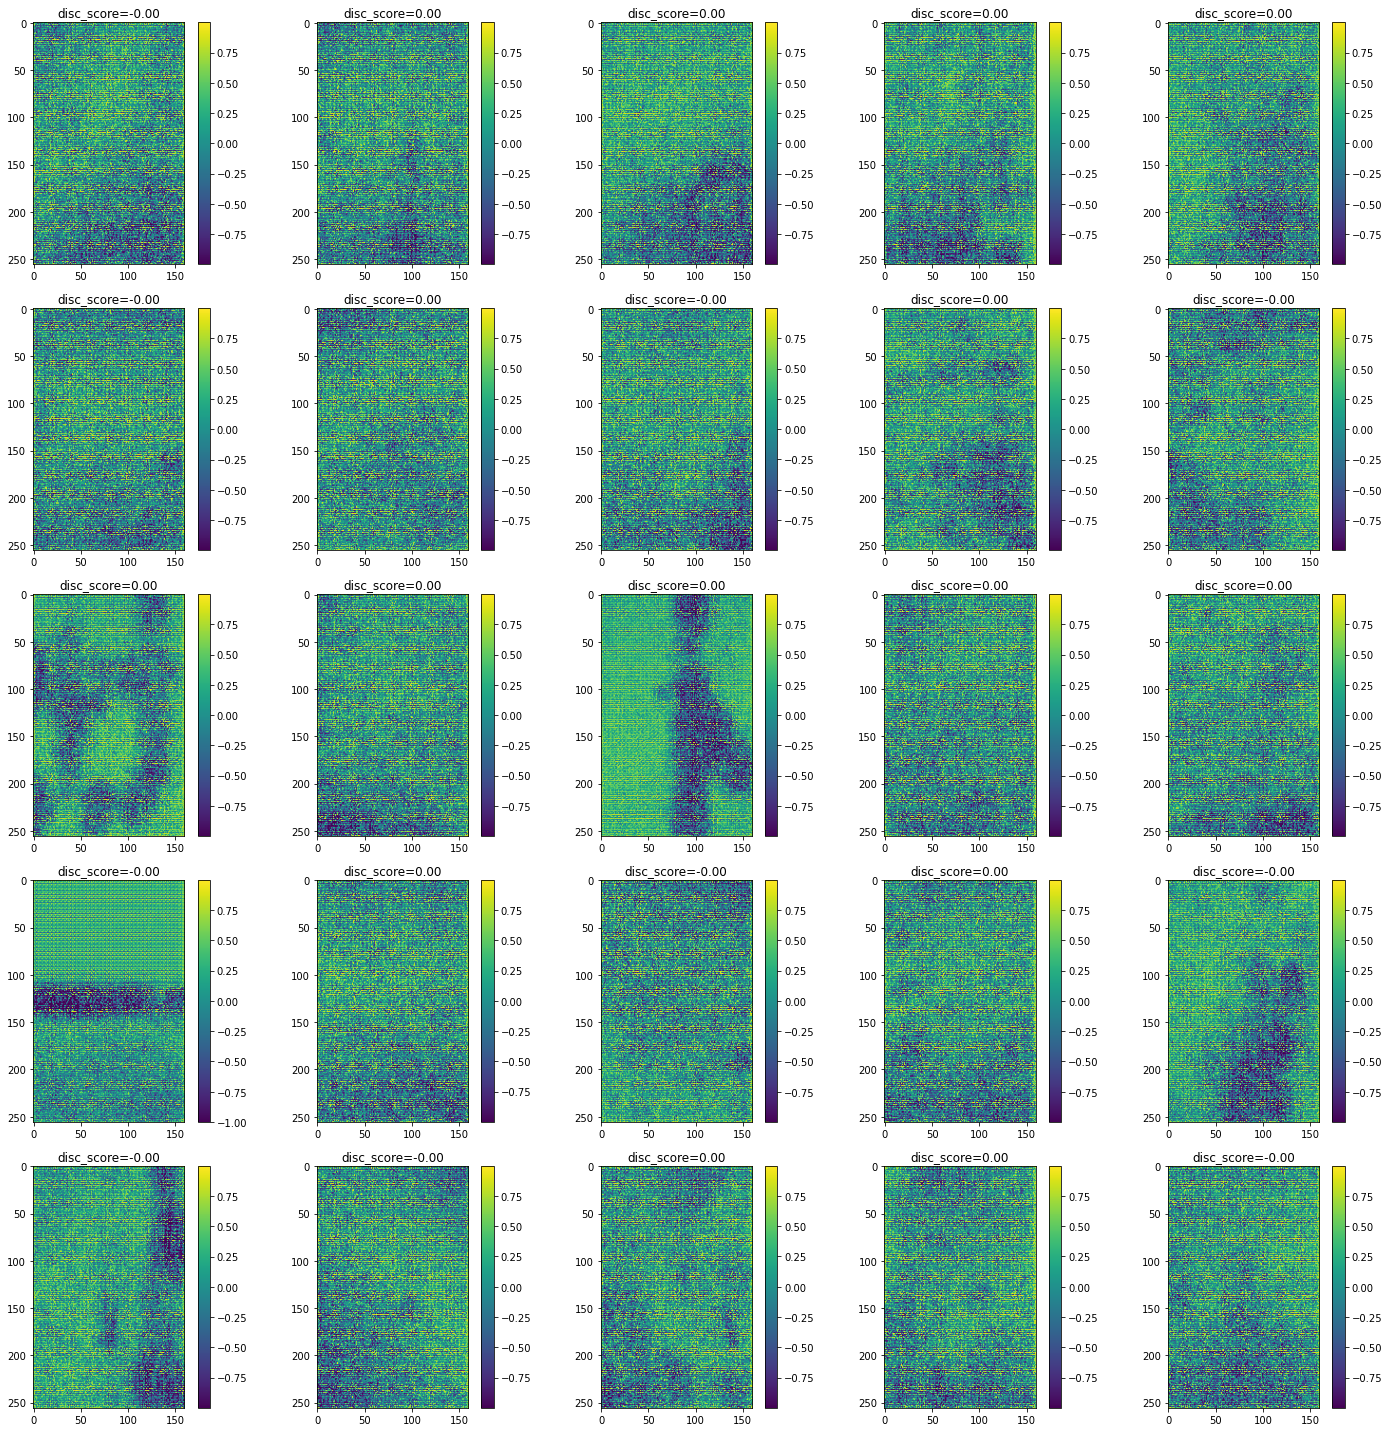

In [14]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    with torch.no_grad():
        img = y_gen(undefective_images[i].to('cuda').unsqueeze(0))
        disc_score = x_disc(img)
        mappable = ax.imshow(img.to('cpu').detach().numpy().squeeze(0).transpose((1, 2, 0)))
        plt.colorbar(mappable, ax=ax)
    ax.set_title(f'disc_score={disc_score.item():.2f}')
plt.tight_layout()